# **Step 1: Import Libraries**

In [1]:
pip install fastai 

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard Libraries
import os
import zipfile
import random
from glob import glob

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms

# Evaluation Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

**Define Parameters**

In [3]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'
LABELS_CSV = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Reproducibility Seed
SEED = 42

# SimCLR pretraining epochs
SIMCLR_EPOCHS = 1

# Fine-tuning epochs
FINETUNE_EPOCHS = 1

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [4]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 2: Load Data**

In [5]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 3: Data Preprocessing**

In [6]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

# **Step 4: Exploratory Data Analysis (EDA)**

**Number of Unique Patients**

In [7]:
unique_patients = labels_df['Patient ID'].nunique()
print(f"Number of Unique Patients: {unique_patients}")

Number of Unique Patients: 30805


**Label Distribution**

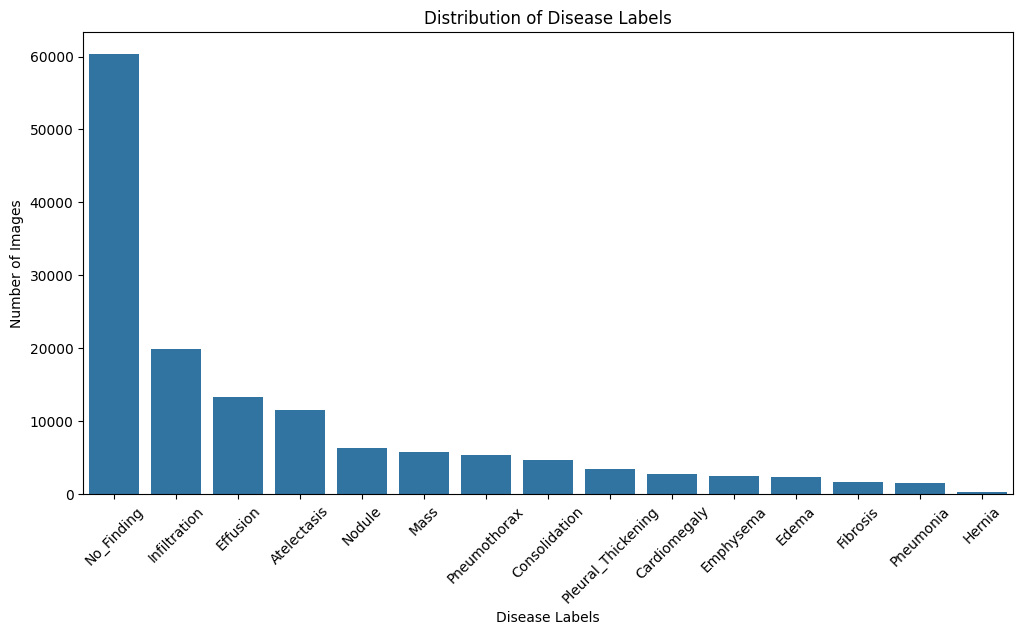

In [8]:
label_counts = labels_df[disease_labels + ['No_Finding']].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Disease Labels")
plt.ylabel("Number of Images")
plt.xlabel("Disease Labels")
plt.show()

**Patient Gender Distribution**

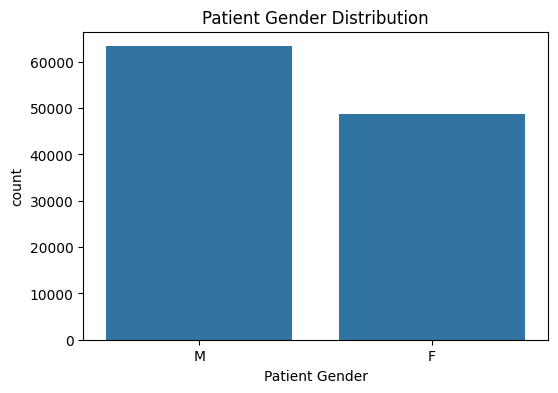

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Gender', data=labels_df)
plt.title("Patient Gender Distribution")
plt.show()

**Patient Age Distribution**

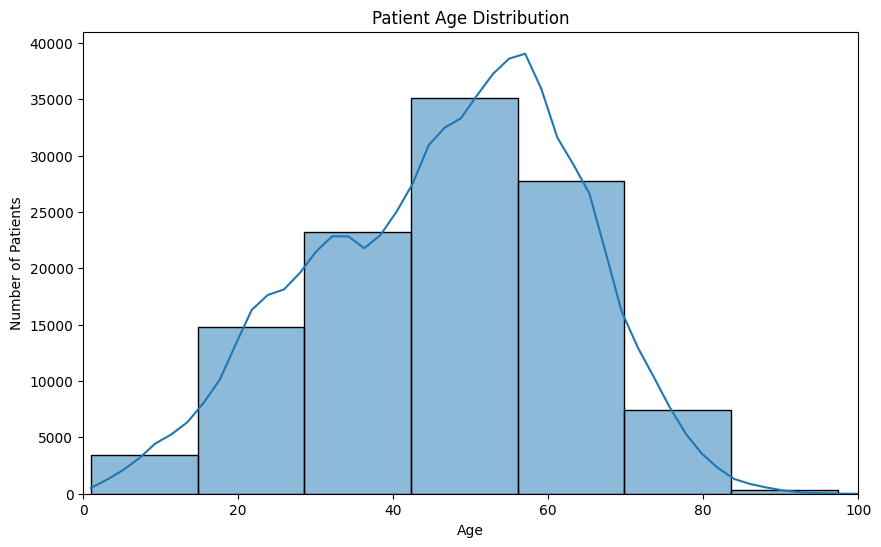

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(labels_df['Patient Age'], bins=30, kde=True)
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.xlim(0, 100)
plt.show()

**View Position Distribution**

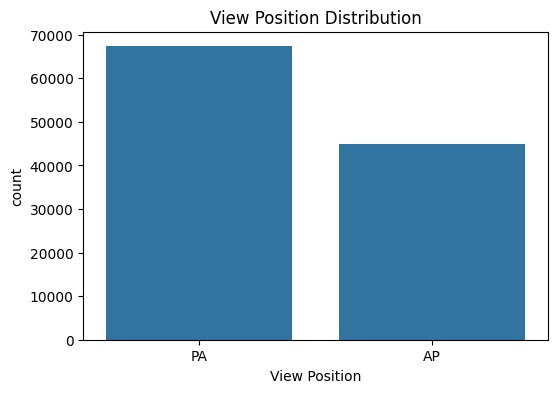

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x='View Position', data=labels_df)
plt.title("View Position Distribution")
plt.show()

**Correlation Matrix for Labels**

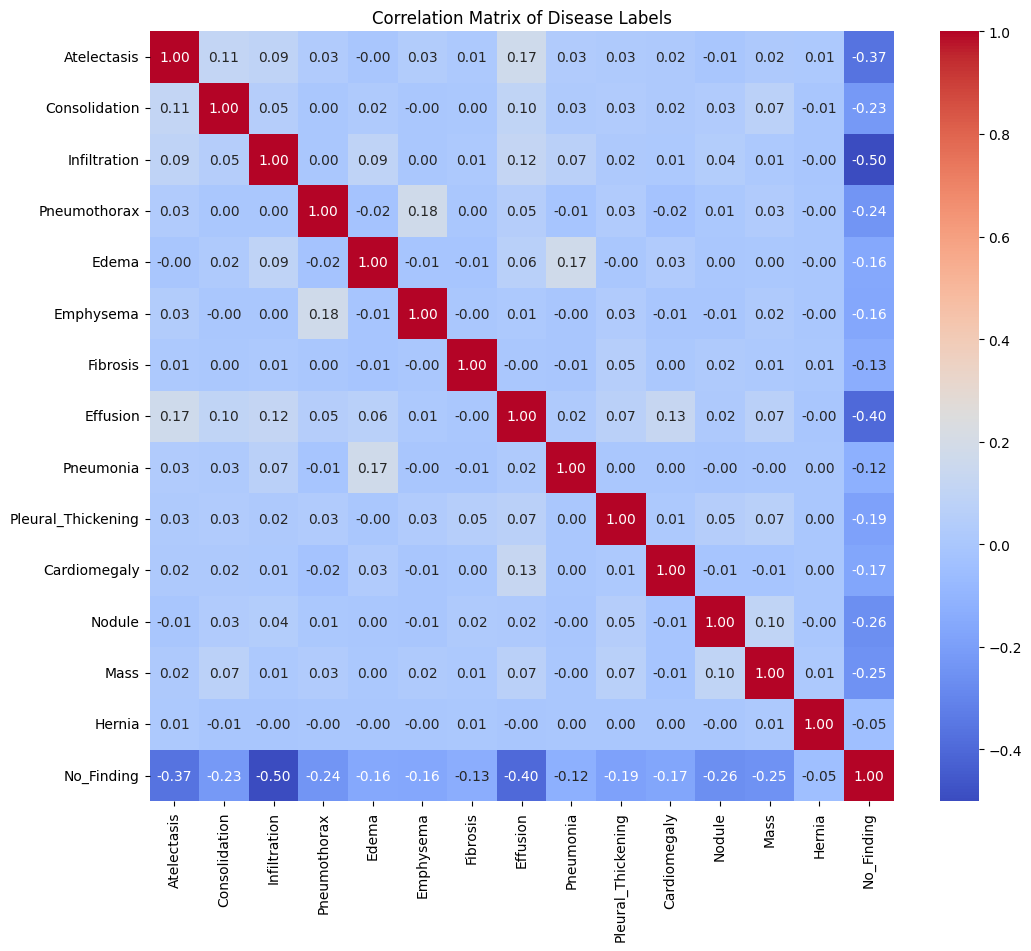

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(labels_df[disease_labels + ['No_Finding']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Disease Labels")
plt.show()

# **Step 5: Split Dataset**

In [13]:
# FastAI Libraries
import fastai
from fastai.vision.all import *

In [14]:
# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


# **Step 6: Contrastive Learning using SimCLR**

**Define the transformation for SimCLR**

In [15]:
class SimCLRTransform:
    """
    Generates two augmented versions of the same image.
    """
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)

In [16]:
# Define the base transformation for SimCLR
simclr_transform = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Randomly resize and crop the image
    transforms.RandomResizedCrop(size=224, scale=(0.2, 1.0)),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),

    # Apply color jitter with specific parameters
    transforms.ColorJitter(
        brightness=0.4,  # How much to jitter brightness
        contrast=0.4,    # How much to jitter contrast
        saturation=0.4,  # How much to jitter saturation
        hue=0.1          # How much to jitter hue
    ),

    # Convert to grayscale with a low probability
    transforms.RandomGrayscale(p=0.2),

    # Apply Gaussian blur
    transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Initialize SimCLR Transform
simclr_data_transform = SimCLRTransform(simclr_transform)

**Create SimCLR Dataset**

In [17]:
class SimCLRDataset(Dataset):
    """
    Custom Dataset for SimCLR.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']
        
        # Load image using PIL and convert to RGB
        image = plt.imread(img_path)

        # Apply SimCLR transformations to get two views
        if self.transform:
            img1, img2 = self.transform(image)
        else:
            img1, img2 = image, image

        return img1, img2

# Recreate SimCLR Dataset with the updated __getitem__ method
simclr_dataset = SimCLRDataset(train_val_df, transform=simclr_data_transform)

**Initialize SimCLR DataLoader**

In [18]:
simclr_loader = DataLoader(simclr_dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=True)

**Define SimCLR Model**

In [19]:
class SimCLRModel(nn.Module):
    """
    SimCLR Model with base encoder and projection head.
    """
    def __init__(self, base_model, projection_dim=128):
        super(SimCLRModel, self).__init__()
        self.encoder = base_model
        self.encoder.head = nn.Identity()  # Remove the classification head

        # Projection head
        self.projection_head = nn.Sequential(
            nn.Linear(self.encoder.num_features, self.encoder.num_features),
            nn.ReLU(),
            nn.Linear(self.encoder.num_features, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return z

# Initialize the base Swin Transformer model
base_swin = models.swin_v2_t(weights=models.Swin_V2_T_Weights.IMAGENET1K_V1)
base_swin.num_features = base_swin.head.in_features

# Initialize SimCLR Model
simclr_model = SimCLRModel(base_model=base_swin).to(device)

**Initialize NT-Xent Loss for SimCLR**

In [20]:

class NTXentLoss(nn.Module):
    """
    Normalized Temperature-Scaled Cross Entropy Loss for SimCLR.
    """
    def __init__(self, batch_size, temperature=0.5, device='cuda'):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.similarity_function = nn.CosineSimilarity(dim=2)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.mask = self._get_correlated_mask().type(torch.bool)

    def _get_correlated_mask(self):
        """
        Creates a mask to identify positive and negative pairs.
        """
        N = 2 * self.batch_size
        mask = torch.ones((N, N), dtype=torch.float32)
        mask = mask.fill_diagonal_(0)
        for i in range(self.batch_size):
            mask[i, self.batch_size + i] = 0
            mask[self.batch_size + i, i] = 0
        return mask.to(self.device)

    def forward(self, z_i, z_j):
        """
        Computes the NT-Xent loss.
        """
        N = 2 * self.batch_size
        z = torch.cat((z_i, z_j), dim=0)

        # Compute similarity matrix
        sim = self.similarity_function(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        # Extract positive similarities
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        positives = torch.cat([sim_i_j, sim_j_i], dim=0).reshape(N, 1)

        # Remove positive similarities from the similarity matrix
        sim = sim[self.mask].view(N, -1)

        # Concatenate positive similarities with the negatives
        logits = torch.cat((positives, sim), dim=1)

        # Labels: positives are the first element in each row
        labels = torch.zeros(N).to(self.device).long()

        # Compute loss
        loss = self.criterion(logits, labels)
        loss /= N
        return loss

# Initialize NT-Xent Loss
criterion_simclr = NTXentLoss(batch_size=32, temperature=0.5, device=device)

**Initialize Optimizer**

In [21]:
optimizer_simclr = optim.Adam(simclr_model.parameters(), lr=1e-4)

**Train SimCLR Model**

In [22]:
def train_simclr(model, data_loader, criterion, optimizer, epochs=100):
    """
    Trains the SimCLR model.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        progress_bar = tqdm(data_loader, desc=f"SimCLR Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            img1, img2 = batch
            img1 = img1.to(device)
            img2 = img2.to(device)

            # Forward pass
            z_i = model(img1)
            z_j = model(img2)

            # Compute loss
            loss = criterion(z_i, z_j)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch+1}/{epochs}] - Average Loss: {avg_loss:.4f}")

    print("SimCLR Training Completed.")

# Start SimCLR pretraining # TODO
# train_simclr(simclr_model, simclr_loader, criterion_simclr, optimizer_simclr, epochs=SIMCLR_EPOCHS) # TODO

# After SimCLR Training is Completed # TODO
# torch.save(simclr_model.encoder.state_dict(), 'simclr_encoder.pth') # TODO
print("SimCLR encoder saved.")



SimCLR encoder saved.


**Load the pretrained SimCLR encoder weights**

In [23]:
simclr_encoder_path = 'simclr_encoder.pth'
simclr_model.encoder.load_state_dict(torch.load(simclr_encoder_path))
simclr_model.encoder.eval()

print("Pretrained SimCLR encoder loaded.")

/tmp/ipykernel_4190348/3287655023.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.encoder.load_state_dict(torch.load(simclr_encoder_path))


Pretrained SimCLR encoder loaded.


# **Step 6: Data Processing Part 2**

**Define Dataset for Chest X-ray images**

In [24]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [25]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image within a range of ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [26]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [27]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [28]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# **Step 7: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [29]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using a pretrained SimCLR encoder.
    """
    def __init__(self, simclr_encoder, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()
        
        # Use the pretrained SimCLR encoder
        self.encoder = simclr_encoder
        
        # Define the classification head
        self.classifier = nn.Sequential(
            nn.Linear(simclr_encoder.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        outputs = self.classifier(features)
        return outputs


# Initialize the Multi-Label Classifier with the pretrained SimCLR encoder
model = MultiLabelClassifier(simclr_encoder=simclr_model.encoder)
model.to(device)

print("Multi-Label Classifier initialized with pretrained SimCLR encoder.")

Multi-Label Classifier initialized with pretrained SimCLR encoder.


**Freeze the encoder parameters**

In [30]:
for param in model.encoder.parameters():
    param.requires_grad = False

print("SimCLR encoder parameters frozen. Only the classification head will be trained.")

SimCLR encoder parameters frozen. Only the classification head will be trained.


**Define Loss Function and Optimizer**

In [31]:
criterion = nn.BCEWithLogitsLoss()

# Only parameters of the classifier will be updated
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# **Step 8: Train the Model**

In [32]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0

        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Start fine-tuning
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=FINETUNE_EPOCHS)

Epoch 1/1:   0%|          | 0/141 [01:48<?, ?it/s, Loss=0.183]

Epoch 1, Training Loss: 0.2133, Validation Loss: 0.1746


# **Step 9: Evaluate the Model**

In [33]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).cpu()  # Apply sigmoid to get probabilities
            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 175/175 [02:01<00:00,  1.44it/s]


**Compute Metrics for Each Label**

In [34]:
accuracy_per_label = {}
roc_auc_per_label = {}

for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5
    acc = accuracy_score(labels[:, i], binary_preds)
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])
    accuracy_per_label[label] = acc
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate overall ROC AUC (average of all labels)
overall_roc_auc = metrics_df['ROC AUC'].mean()
metrics_df.loc['Overall'] = metrics_df.mean()

print(metrics_df)

                    Accuracy   ROC AUC
Atelectasis         0.901005  0.678353
Consolidation       0.957343  0.739561
Infiltration        0.816229  0.645606
Pneumothorax        0.954248  0.714537
Edema               0.979636  0.787069
Emphysema           0.976182  0.662856
Fibrosis            0.983673  0.611562
Effusion            0.885485  0.737598
Pneumonia           0.986813  0.614200
Pleural_Thickening  0.970396  0.587548
Cardiomegaly        0.972280  0.665587
Nodule              0.942585  0.560314
Mass                0.951736  0.600998
Hernia              0.997847  0.568802
Overall             0.948247  0.655328


**Plot ROC curves for each label**

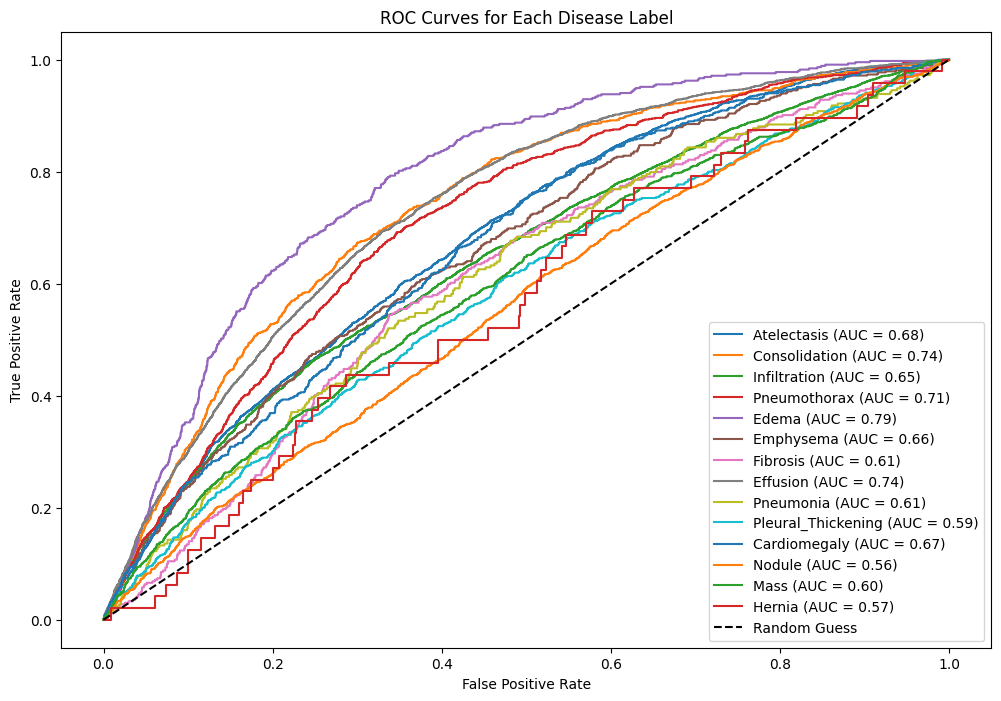

In [35]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()
